# 1. Project Overview

hiiiii

## Main Objective 

The objective of this project is to:

* Build a series of regression models using the provided dataset
* Evaluate and compare different models performance
* Apply various techniques to improve model accuracy and prevent overfitting.


The focus will be on both **linear** and **nonlinear** regression models. 
In addition this project will also use **feature selection methods** and **regularization techniques**, followed by **hyperparameter tuning**, to select the optimal model.


## Data Set Description

This dataset includes around 6,750 rows and 9 columns. It’s well-suited for Exploratory DataAnalysis (EDA) and machine learning tasks, particularly for predictive modeling usingalgorithms like Linear Regression. 

The main objective of this dataset is to **predict car prices**, making it ideal for developing regression models to understand the relationship between various features and **the target variable (car price)**.



The table below describes the dataset columns:

| **Column**         | **Description**                              | **Measurement Level** |
|---------------------|----------------------------------------------|-----------------------|
| Car Name           | The name of the car                          | Nominal               |
| Price              | The price of the car                         | Numeric               |
| Engine Capacity    | The car engine capacity                      | Numeric               |
| Cylinder           | The car cylinder power                       | Numeric               |
| Horse Power        | The car horse power                          | Numeric               |
| Top Speed          | The car top speed                            | Numeric               |
| Seats              | Number of seats in the car                   | Numeric               |
| Brand              | The car brand                                | Nominal               |
| Country            | The country where the site sells this car    | Nominal               |


# 2. Data Preprocessing 

## First: Import Dataset

The code below is responsible for importing data and also displaying quick describtion:

In [109]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
df=pd.read_csv('/kaggle/input/cars-dataset/cars.csv')
print ('successfully imported the dataset')

/kaggle/input/cars-dataset/cars.csv
successfully imported the dataset


In [110]:
df.describe()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
count,6308,6308,6308,5684,6308,6308,6308,6308,6308
unique,2546,3395,129,10,330,169,82,82,7
top,Mercedes-Benz C-Class 2022 C 300,TBD,2.0,4,150,250,5 Seater,mercedes-benz,uae
freq,10,437,1241,2856,162,1100,3471,560,1248


In order to understand the data further below we count the number of unique values in each column and their frequency:

In [111]:
for col in df.columns:  # Iterate over column names in the DataFrame
    # Print the name of the column and its type
    print(f'Name: {col} dtype: {df[col].dtype}\n')
    # Print each unique value with its frequency
    print(f'{df[col].value_counts()}\n')
    # Print a separator
    print(('-' * 100) + '\n\n')

Name: car name dtype: object

car name
Mercedes-Benz C-Class 2022 C 300                             10
Porsche 911 2021 Carrera Cabriolet                            7
Land Rover Range Rover Sport 2021 5.0L V8 SVR (575 PS)        7
Mercedes-Benz V Class 2021 Exclusive                          7
MG GT 2022 1.5T Comfort                                       7
                                                             ..
Jaguar F-Type Convertible 2021 3.0L V6                        1
Jaguar F-Type Coupe 2021 3.0L V6 (380 PS)                     1
BMW X3 2021 m40i xDrive                                       1
Jaguar F-Type Convertible 2021 3.0L V6 R-Dynamic (340 PS)     1
Jaguar F-Pace 2021 35t R-Sport                                1
Name: count, Length: 2546, dtype: int64

----------------------------------------------------------------------------------------------------


Name: price dtype: object

price
TBD               437
Following         238
DISCONTINUED      140
Follow        

#### What can we notice from each column?
1. The column car name serves as an identifier and not missing for any of the cars and so no more processing needed.
2. The price is listed in different currency. Further, some are (TBD, Following, Discountinued), these entries need to be removed for Linear regression because missing target values make it impossible to calculate the error or fit the model properly.
3. The engine capacity is not standard some are denoted in liters as (1.4, 2.6) and others are in cubic centimeters like (1,400) and these need to be standraized
4. The cyclinder column has N/A values for electric cars, because the do not have cyclinders and this needs to be handled. Also some are as (Single or Double) that needs to be handled.
5. the top speed column has some incorrect entries(like 4 Seaters ) and this is incorrect and need to be handled. Further some values are (automatic or N A) and these needs to be addressed.
6. The seats column has some incorrrect entries , either floats or too large entries like 150.
7. The brand and country is correctly entered for all.


## Second: Data Cleaning

In this part we want to perform the following:


* Handle missing values
* Handle incorrect entries or values
* Encoding categorical features (if applicaple)
* Normalize or standardize numerical features (if necessary)
* Split the dataset into: 60% for training, 20% for validation, and 20% for testing


### Handle missing values

We want to start by removing any missing values from the data set:

In [112]:
def remove_missing_price(df):
    """
    Removes rows where the 'price' column is missing (NaN or contains specific keywords).
    Displays the number of rows before and after removal.
    """
    print(f'Rows before removal: {len(df)}')

    # Define missing keywords to check within the 'price' column
    missing_keywords = ['TBD', 'N A', 'Following', 'DISCONTINUED']

    # Remove rows where 'price' is NaN
    df = df.dropna(subset=['price'])

    # Remove rows in the 'price' column that contain any of the missing keywords
    df = df[~df['price'].astype(str).str.contains('|'.join(missing_keywords), case=False, na=False)]

    print(f'Rows after removal: {len(df)}')

    return df

# Apply the function
df = remove_missing_price(df)


Rows before removal: 6308
Rows after removal: 5493


In [113]:
def remove_missing_values(df):
    """
    Removes rows containing missing keywords and displays the number of rows before and after removal.
    """
    print(f'Before Removing: {len(df)}')

    # Remove rows with any missing value
    df.dropna(how='any', inplace=True)
    
    # Remove rows with any missing keywords
    missing_keywords = ['TBD', 'N A', 'Following', 'DISCONTINUED']

    # Remove rows containing any of the missing keywords
    df = df[~df.apply(lambda row: row.astype(str).str.contains('|'.join(missing_keywords), case=False, na=False).any(), axis=1)]

    print(f'After Removing: {len(df)}')

    return df


df = remove_missing_values(df)


Before Removing: 5493
After Removing: 4771


### Handle incorrect values

Here we want to analyze the colums given insights noted after imoorting and fix any incorrent discrepancies.

#### Price : 

To ensure consistency, we need to standardize all prices to a common currency, here we'll use USD, for a uniform target variable. This will help avoid discrepancies and improve the accuracy of any predictive modeling

In [114]:
def apply_price_adj(price):
    """
    Converts a price string with a currency code into USD.
    """
    try:
        # Extract the currency code (first 3 characters)
        currency_code = price[:3].strip()
        # Extract the price string (everything after the currency code) and remove commas
        price_str = price[4:].replace(',', '').strip()
        # Convert price to float
        price_value = float(price_str)

        # Currency conversion rates as of 20 Nov 2024
        conversion_rates = {
            'AED': 0.27,   # 1 AED = 0.27 USD
            'KWD': 3.28,   # 1 KWD = 3.28 USD
            'OMR': 2.60,   # 1 OMR = 2.60 USD
            'BHD': 2.65,   # 1 BHD = 2.65 USD
            'QAR': 0.25,   # 1 QAR = 0.25 USD
            'SAR': 0.27,   # 1 SAR = 0.27 USD
            'EGP': 0.021   # 1 EGP = 0.021 USD
        }

        # Convert to USD if the currency code is valid
        if currency_code in conversion_rates:
            price_in_dollars = price_value * conversion_rates[currency_code]
            return round(price_in_dollars, 3)  # Round to three decimal places
        else:
            # Return NaN if the currency code is not recognized
            return float('nan')

    except (ValueError, IndexError):
        # Return NaN for invalid input or parsing errors
        return float('nan')



# Apply the function to replace the 'price' column values 
df['price'] = df['price'].apply(apply_price_adj)

# Drop rows where 'price' is NaN
df.dropna(subset=['price'], inplace=True)

# Save the cleaned DataFrame to a CSV file
df.to_csv('/kaggle/working/output3.csv', index=False)

#### Engine Capacity :
To ensure consistency, we need to standardize all engine capacities to liters and see we would need to convernt any valus in cubic centimerts to litres.

In [115]:
def apply_engine_adj(capacity):
    """
    Standardizes engine capacity to liters.
    If the value is greater than 1000, it is assumed to be in cubic centimeters (cc) and converted to liters.
    Otherwise, it is treated as already in liters.
    """
    try:
        # Convert to float for comparison
        engine_capacity = float(capacity)

        # Check if the value is larger than 1000
        if engine_capacity > 1000:
            engine_capacity = engine_capacity / 1000  # Convert cc to liters
        return round(engine_capacity, 2)  # Return value in liters, rounded to 2 decimals

    except (ValueError, TypeError):
        # Return NaN for invalid input or parsing errors
        return float('nan')


# Apply the function to replace the 'engine' column values 
df['engine_capacity'] = df['engine_capacity'].apply(apply_engine_adj)

# Drop rows where 'price' is NaN
df.dropna(subset=['engine_capacity'], inplace=True)

# Save the cleaned DataFrame to a CSV file
df.to_csv('/kaggle/working/output4.csv', index=False)

#### Cylinder:
We will apply feature extranction here, for electric cars there is no cylinders , so we will add a column to mark if electric or not. In the cylider column if electric we will set to 0.



**Why -1 ?**

For most vehicles, cylinder counts are typically 3, 4, 6, 8, 10 or 12, using a negative value does not overlap with valid cylinder counts (e.g., 3, 4, 6, 8, etc.).
It explicitly indicates the absence of a conventional cylinder count, making it interpretable as "no cylinders."

In [116]:
def apply_cylinder_adj(capacity):
    """
    Adjusts the cylinder values. If the value is 'Electric' or 'N/A', it returns -1.
    """
    try:
        # Handle Electric and N/A cases
        if capacity in ['N/A, Electric']:
            return 0
          # Return numeric values as they are
        return float(capacity)
    except (ValueError, TypeError):
        # Return NaN for invalid inputs
        return float('nan')

# Apply the function to adjust the 'cylinder' column
df['cylinder'] = df['cylinder'].apply(apply_cylinder_adj)


# Save the cleaned DataFrame to a CSV file
df.to_csv('/kaggle/working/output5.csv', index=False)



#### Horse Power:

Replace Single, Double, Triple with their standard values

In [117]:
def apply_horse_adj(capacity):
    """
    Adjusts the horsepower values. If the value matches 'Single', 'Double', or 'Triple',
    it replaces them with their corresponding horsepower values These values are averages taken from online sources. 
    Otherwise, numeric values remain unchanged.
    """
    horsepower_dict = {
        'Single': 283,
        'Double': 422.0,
        'Triple': 810.0
    }
    
    try:
        return float(capacity)
    except (ValueError, TypeError): # if not already numeric
        # Map known strings to their corresponding horsepower values
        return horsepower_dict.get(capacity, float('nan'))  # NaN for unrecognized strings

# Apply the function to adjust the 'horse_power' column
df['horse_power'] = df['horse_power'].apply(apply_horse_adj)

# Drop rows with NaN in 'horse_power' (invalid entries)
df.dropna(subset=['horse_power'], inplace=True)

# Save the cleaned DataFrame to a CSV file
df.to_csv('/kaggle/working/output6.csv', index=False)


#### Speed:

Remove any non-numeric values.

In [118]:
def apply_top_speed_adj(speed):
    """
    Cleans and standardizes the top_speed values.
    If the value is non-numeric (e.g., 'N/A', 'Unknown'), it is converted to NaN.
    Otherwise, it is treated as a valid numeric value.
    """
    try:
        # Attempt to convert the value to a float
        return float(speed)
    except (ValueError, TypeError):
        # Return NaN for invalid input or parsing errors
        return float('nan')


# Apply the function to replace the 'top_speed' column values
df['top_speed'] = df['top_speed'].apply(apply_top_speed_adj)

# Drop rows where 'top_speed' is NaN
df.dropna(subset=['top_speed'], inplace=True)

# Save the cleaned DataFrame to a CSV file
df.to_csv('/kaggle/working/output7.csv', index=False)

#### Seats:

We need to extract seats into their numeric values:

Note : reaching this here some values that were already invalid like floats (1.4, 2.5) and large values (150), were already removed since there has been multiple issue with that records entry.

In [119]:
def apply_seats_adj(seats_string):
    """
    Extracts the number of seats from a string assuming this format '5 Seater'.
    """
    try:
        # Split the string and extract the first part as an integer
        return int(seats_string.split()[0])
    except (ValueError, AttributeError, IndexError):
        # Return NaN for invalid or unparsable values
        return float('nan')

# Apply the function to the 'seats' column
df['seats'] = df['seats'].apply(apply_seats_adj)

# Drop rows where 'seats' is NaN
df.dropna(subset=['seats'], inplace=True)

# Save the cleaned DataFrame to a CSV file
df.to_csv('/kaggle/working/output8.csv', index=False)


#### Summary:

The current number of records is 4078, the original was 6038. We lost around 35% of the data, we will continue and assume acceptable with that since the data has many issues and descripincies in the start.

In [120]:
print (len(df))

4078


### Encode Categorical


**Perform one-hot encoding for country.**

In [121]:
def encode_countries(df):
    # One-hot encode the 'country' column
    df_encoded = pd.get_dummies(df, columns=['country'], dtype=int, drop_first=True)    
    
    return df_encoded

df = encode_countries(df)
print (df.head())

                             car name     price  engine_capacity  cylinder  \
2    Suzuki Jimny 2021 1.5L Automatic  26671.95              1.5       4.0   
5       Honda HR-V 2021 1.8 i-VTEC EX  25740.45              1.8       4.0   
8   Renault Koleos 2021 2.5L LE (4WD)  31563.00              2.5       4.0   
10         Suzuki Jimny 2021 1.5L M/T  24808.95              1.5       4.0   
11      Honda HR-V 2021 1.8 i-VTEC DX  19530.45              1.8       4.0   

    horse_power  top_speed  seats    brand  country_egypt  country_ksa  \
2         102.0      145.0    4.0   suzuki              0            1   
5         140.0      190.0    5.0    honda              0            1   
8         170.0      199.0    5.0  renault              0            1   
10        102.0      145.0    4.0   suzuki              0            1   
11        140.0      190.0    5.0    honda              0            1   

    country_kuwait  country_oman  country_qatar  country_uae  
2                0     

**Perform Target encoding for country**

Note: What is target encoding? 

[Article on Comparing Performances of Encoding Schemes on Regression with Cross-validation](http://https://www.linkedin.com/pulse/comparing-performances-encoding-schemes-regression-imran-khan-jb3xc/)

Also see:
[1](https://towardsdatascience.com/benchmarking-categorical-encoders-9c322bd77ee8)
[2](https://medium.com/anolytics/all-you-need-to-know-about-encoding-techniques-b3a0af68338b)




* Mean encoding involves replacing each category with the mean value of the target variable for that category. This method can be very effective, especially for supervised learning tasks, but it can lead to overfitting if not managed properly
* When to use: It is suitable for categorical features exhibiting a **high number of categories**. 
* Because we wil later use regularization techniques, this will be safe to use.
*  Target encoding leverages the relationship between categorical variables and the target variable, making it a powerful encoding technique when this relationship is significant.
* One of the significant drawbacks of target encoding is the potential for overfitting, especially when applied to small datasets. It suffers from the problem of target leakage as the target variable is used to directly encode the input feature and the same feature is used to fit a model on the target variable.
* -> This is important to note because this type of encoding should only be applied on the training data after the split

Correct Approach -> Fit the Encoder Only on Training Data:

The encoder learns the target means for each category in the training data, and then  we use the fitted encoder to apply the same encoding to validation and test datasets.


In [122]:
from sklearn.model_selection import train_test_split 
import category_encoders as ce

def encode_brand(train_df):
    # Initialize the MeanEncoder
    mean_encoder = ce.TargetEncoder()
    
    # Fit the encoder on the training data
    mean_encoder.fit(train_df['brand'], train_df['price'])
    
    # Encode the 'brand' column
    train_df['brand'] = mean_encoder.transform(train_df[['brand']])['brand'].round(2)
    
    # Normalize the encoded 'brand' column using z-score normalization
    scaler = StandardScaler()
    train_df['brand'] = scaler.fit_transform(train_df[['brand']])
    
    return train_df, mean_encoder, scaler


### Normalize Numeric


#### Z-Score normalization 

Best for many advatages and reasons.

In [123]:
from sklearn.preprocessing import StandardScaler 
numeric_features = ['engine_capacity', 'cylinder', 'horse_power', 'seats', 'top_speed']

# Use the z-score normalization 
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

df.to_csv('/kaggle/working/output9.csv', index=False)

### Split Data:

A commin split that is used here is 60% for training, 20% for validation, and 20% for testing.


In [124]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Shuffle the dataset
df_shuffled = shuffle(df, random_state=42) # note that 42 is a widely used convention but can be anything -> this is used for consistent reproducability of the data

# Split the data into training (60%) and temp (40%)
train_data, temp_data = train_test_split(df_shuffled, test_size=0.4, random_state=42)

# Split the temp data into validation and testing 
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Output the sizes of each split to verify
print (len(train_data))
print (len(val_data))
print(len(test_data))

# remember to encode and normalize brand here 
train_data,encoder,scaler = encode_brand(train_data)

# Transform and normalize validation and test data
val_data['brand'] = encoder.transform(val_data[['brand']])['brand']
val_data['brand'] = scaler.transform(val_data[['brand']])

test_data['brand'] = encoder.transform(test_data[['brand']])['brand']
test_data['brand'] = scaler.transform(test_data[['brand']])



2446
816
816


In [125]:
# Save the train data DataFrame to a CSV file
train_data.to_csv('/kaggle/working/outputf.csv', index=False)
val_data.to_csv('/kaggle/working/outputff.csv', index=False)

**Extra : Visulaizing correlation between features**

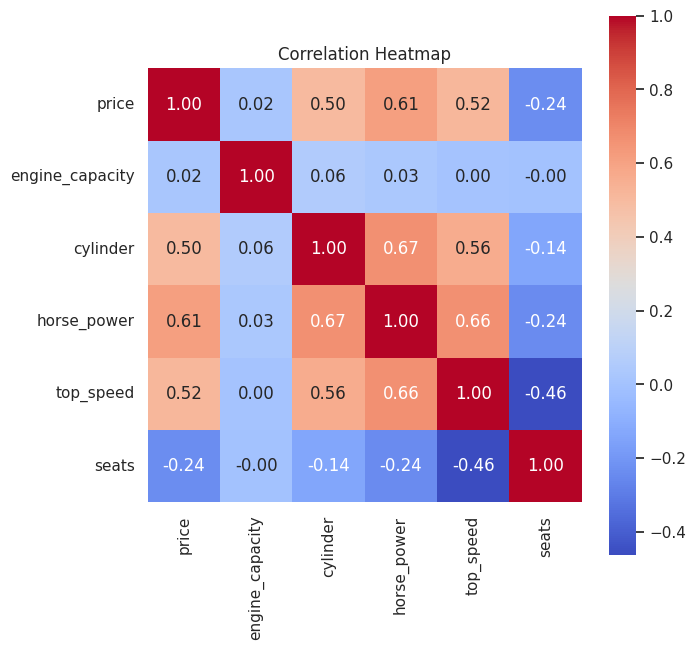

In [126]:

f_num = ['price', 'engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats']

# Filter the dataset to include only the selected numerical columns
dataset_corr = df[f_num]

# Compute the correlation matrix
correlation_matrix = dataset_corr.corr()

# Plot the heatmap
plt.figure(figsize=(7, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap')
plt.show()

# 3. Building Regression Models 

In [127]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Utility Functions for all models to prepare for use of models

def set_up_features():
    global X_train, y_train, X_val, y_val, X_test, y_test  # Declare variables as global

    # Define features (X) and target (y) for training, validation, and test sets
    X_train = train_data.drop(columns=['car name', 'price'])  
    y_train = train_data['price']

    X_val = val_data.drop(columns=['car name', 'price'])  
    y_val = val_data['price']

    X_test = test_data.drop(columns=['car name', 'price'])  
    y_test = test_data['price']



def evaluate_model(y_predicted, y_truth=None):
    global y_test
    
    # Use y_test by default if no other y is provided -> used because we sometimes use validation set 
    if y_truth is None:
        y_truth = y_test
    
    # Evaluate the model
    mse = mean_squared_error(y_truth, y_predicted)
    r2 = r2_score(y_truth, y_predicted)
    mae = mean_absolute_error(y_truth, y_predicted)

    return mse, r2, mae


def print_evaluation (mse, r2, mae):    
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Absolute Error: {mae}")
    
    

def export_model(y_predicted, name):
    global test_data, y_test
    # Combine 'car name', original 'price', and predicted 'price' into a DataFrame
    results = pd.DataFrame({
        'car name': test_data['car name'],
        'original_price': y_test,
        'predicted_price': y_predicted
    })
    
    # Save the DataFrame to a CSV file
    results.to_csv(f'{name}_test_predictions.csv', index=False)  
    print(f"Predictions saved to '{name}_test_predictions.csv'")


set_up_features()

## Linear Models

### Simple Model

This was just developed as a test to test data and linear model.

In [128]:
from sklearn.linear_model import LinearRegression

def simple_linear_model(X_train, y_train, X_test, y_test):  
    # Initialize the Linear Regression model
    model = LinearRegression()
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Evaluate the model on the test data
    y_predicted = model.predict(X_test)
  
    return y_predicted
    

y_predicted = simple_linear_model(X_train, y_train, X_test, y_test)
mse,r2,mae = evaluate_model(y_predicted)
print_evaluation (mse,r2,mae)
export_model (y_predicted, 'simple_linear')

Mean Squared Error: 5685068128.788385
R^2 Score: 0.4526682139006497
Mean Absolute Error: 29432.002775983754
Predictions saved to 'simple_linear_test_predictions.csv'


### Closed-form solution

# Linear Regression with Multiple Features (5 Features) 

note: edit this part -> see forward and backward pass

Linear regression can be generalized to handle multiple features. The model equation with \(n\) features is:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n x_n + \epsilon
$$

In matrix notation, this becomes:

$$
\mathbf{y} = \mathbf{X} \boldsymbol{\beta} + \boldsymbol{\epsilon}
$$

Where:


- **\(\mathbf{y}\): Target vector**  
  Dimensions: \(m \times 1\)

- **\(\mathbf{X}\): Feature matrix**  
  Dimensions: \(m \times (n+1)\), where \(n+1\) includes the intercept term (a column of 1s for \(\beta_0\)).

- **\(\boldsymbol{\beta}\): Coefficient vector to be learned**  
  Dimensions: \((n+1) \times 1\)

- **\(\boldsymbol{\epsilon}\): Error vector**  
  Dimensions: \(m \times 1\)

For a problem with 5 features:
- **\(\mathbf{X}\): Feature matrix**  
  Dimensions: \(m \times 6\) (5 features + 1 intercept)

- **\(\boldsymbol{\beta}\): Coefficient vector**  
  Dimensions: \(6 \times 1\) (1 intercept + 5 coefficients)


---

## Steps to Solve Using Closed-Form Solution

### 1. Construct the Feature Matrix (\(\mathbf{X}\))

Add a column of 1s to the matrix representing the intercept term:

$$
\mathbf{X}_{\text{with intercept}} = 
\begin{bmatrix}
1 & x_{1,1} & x_{1,2} & \cdots & x_{1,5} \\
1 & x_{2,1} & x_{2,2} & \cdots & x_{2,5} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{m,1} & x_{m,2} & \cdots & x_{m,5}
\end{bmatrix}
$$

### 2. Define the Target Vector (\(\mathbf{y}\))

Use the actual observed values for the dependent variable.

### 3. Calculate the Coefficients (\(\boldsymbol{\beta}\))

Use the **Normal Equation** to compute the coefficients:

$$
\boldsymbol{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$

This formula minimizes


In [129]:

import numpy as np

def closed_form_model(X_train, y_train, X_test, y_test):

    # add bias feature 
    X_train = np.hstack((np.ones((train_data.shape[0], 1)), X_train))
    X_test = np.hstack((np.ones((test_data.shape[0], 1)), X_test))
     
    # Closed-form solution for linear regression
    # beta = (X^T * X)^(-1) * X^T * y
    beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
    
    # Make predictions on test sets
    y_predicted = X_test @ beta
    
    return y_predicted, beta


y_predicted, beta = closed_form_model(X_train, y_train, X_test, y_test)
mse,r2,mae = evaluate_model(y_predicted)
print_evaluation (mse,r2,mae)
export_model (y_predicted, 'closed_form')


Mean Squared Error: 5685068128.788381
R^2 Score: 0.45266821390065015
Mean Absolute Error: 29432.002775983707
Predictions saved to 'closed_form_test_predictions.csv'


### Gradient descent 

Mean Squared Error: 5687710280.364677
R^2 Score: 0.45241383989691974
Mean Absolute Error: 29396.637799683023
Predictions saved to 'gradient_descent_test_predictions.csv'


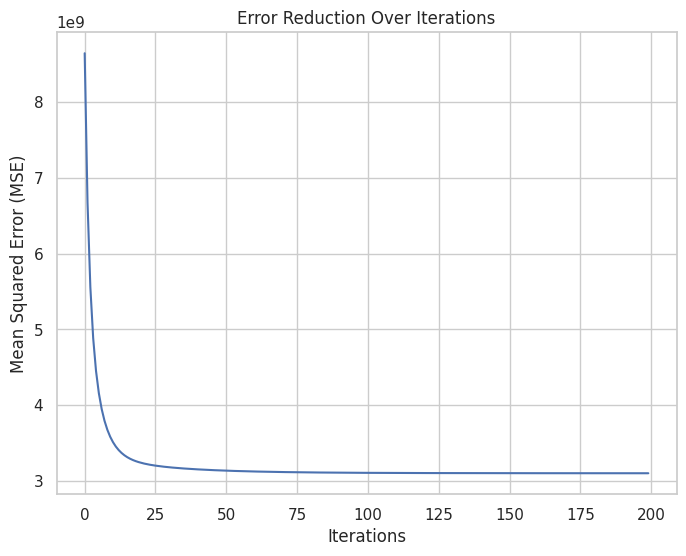

In [130]:
import numpy as np
import matplotlib.pyplot as plt


# find linear regression with visualizing
def gradient_descent_model(X_train, y_train, X_test, y_test, alpha , num_iterations):

    # add bias feature 
    X_train = np.hstack((np.ones((train_data.shape[0], 1)), X_train))
    X_test = np.hstack((np.ones((test_data.shape[0], 1)), X_test))

    num_samples = X_train.shape[0]  # Number of samples 
    num_features = X_train.shape[1]  # Number of features or weights
    
    w = np.random.randn(num_features)  # Initialize initial weights randomly -> we have 13 weights 
    
    errors = []  # To store MSE at each iteration to visualize


    for t in range(num_iterations):
        # find predictions
        y_pred = X_train @ w
        
        # Compute gradient which equal to derivative 
        gradient = -(1 / num_samples) * (X_train.T @ (y_train - y_pred))
        
        # Update weights based on gradient and alpha
        w = w - alpha * gradient
        
        # Calculate MSE and store it 
        error = (1 / (2 * num_samples)) * np.sum((y_train - y_pred) ** 2)
        errors.append(error)

    # Predict on the test set using the final weights
    y_test_pred = X_test @ w
    
    return y_test_pred, errors
    


alpha = 0.1
num_iterations = 200

y_predicted, errors = gradient_descent_model(X_train, y_train, X_test, y_test, alpha , num_iterations)
mse,r2,mae = evaluate_model(y_predicted)
print_evaluation (mse,r2,mae)
export_model (y_predicted, 'gradient_descent')
   
# Visualize Error over Iterations
plt.figure(figsize=(8, 6))
plt.plot(range(num_iterations), errors)
plt.title("Error Reduction Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Mean Squared Error (MSE)")
plt.grid(True)
plt.show()




### Ridge Regression

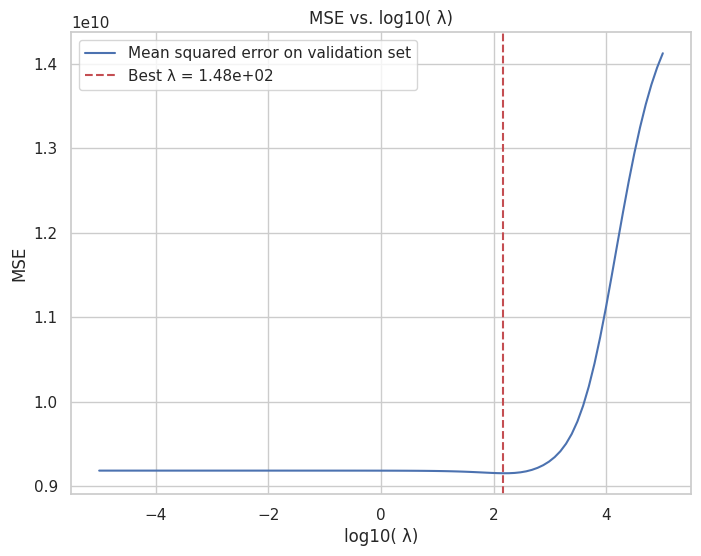

Best value for lambda is: 148.49682622544634
Mean Squared Error: 5602608999.037725
R^2 Score: 0.4606069934797513
Mean Absolute Error: 27364.80833193836
Predictions saved to 'ridge_test_predictions.csv'


In [131]:
import numpy as np


def ridge_regularization_model (X_train, y_train, X_test, y_test, alpha):
    
    X_train = np.hstack((np.ones((train_data.shape[0], 1)), X_train))
    X_test = np.hstack((np.ones((test_data.shape[0], 1)), X_test))

    num_samples = X_train.shape[0]  # Number of samples 
    num_features = X_train.shape[1]  # Number of features or weights

    ## Perform Training:
    # Create an identity matrix 
    I = np.identity(num_features)
    # Execlude the bias feature from regularization
    I[0,0] = 0

    # Solution to ridge regression 
    weights = np.linalg.inv(X_train.T.dot(X_train) + (alpha * I)).dot(X_train.T).dot(y_train)

    ## Perform Prediction:
    # make final prediction on test set using weights
    y_test_pred = X_test.dot(weights) 

    return y_test_pred


# Grid search to find the best value of lambda 
def best_lambda (X_train, y_train, X_val, y_val):
    
    lambdaValues = np.logspace(-5,5,100) # test values from 10^-5 to 10^5 
    MSE_Values = [] 

    for l in lambdaValues: 

        # perfom training on the train data and perform prediction on the validation data 
        y_predicted = ridge_regularization_model (X_train, y_train,X_val,y_val,l)

        # evaluate model between validation and prediction
        MSE_error = evaluate_model(y_predicted, y_val) [0]
        MSE_Values.append(MSE_error)
        
    # find the index of the lowest mean squared error
    index = np.argmin(MSE_Values)

    best_value = lambdaValues[index]
    # Plot the relation between lambda and the mean squared error on the validation set
    plt.figure(figsize=(8, 6))
    plt.plot(np.log10(lambdaValues), MSE_Values, label='Mean squared error on validation set')
    plt.axvline(np.log10(best_value), color='r', linestyle='--', label=f'Best λ = {best_value:.2e}')
    plt.xlabel('log10( λ)')
    plt.ylabel('MSE')
    plt.title('MSE vs. log10( λ)')
    plt.legend()
    plt.show()

    print(f"Best value for lambda is: {best_value}")
    return best_value 


alpha = best_lambda (X_train, y_train, X_val, y_val)

y_predicted = ridge_regularization_model (X_train, y_train, X_test, y_test,alpha)
mse,r2,mae = evaluate_model(y_predicted)
print_evaluation (mse,r2,mae)
export_model (y_predicted, 'ridge')



### LASSO Regression

In [132]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV 


def LASSO_regularization_model (X_train, y_train, X_test, y_test,X_val, y_val):

    # use built-in library
    lasso = Lasso()

    # Define differnt values of alpha to find the best value 
    parameter_values  = {'alpha': [0.0001,0.001, 0.001, 0.01, 1, 10, 100, 1000]}

    # apply grid search to find the best value for the parameter alpha
    lasso = GridSearchCV(lasso, parameter_values, cv = 10, n_jobs = -1)

    
    lasso.fit(X_train, y_train)

    # Evaluate the model on the validation set  
    y_val_predected =lasso.predict(X_val)
    mse,r2,mae = evaluate_model(y_val_predected, y_val)
    print("On validation :")
    print_evaluation (mse,r2,mae)
    
    # Evaluate the model on the test set  
    y_test_predected = lasso.predict(X_test)
    mse,r2,mae = evaluate_model(y_test_predected, y_test)
    print("\nOn test :")
    print_evaluation (mse,r2,mae)


# call LASSO regularization
LASSO_regularization_model (X_train, y_train, X_test, y_test,X_val, y_val)


On validation :
Mean Squared Error: 9094615712.624052
R^2 Score: 0.3882528658177953
Mean Absolute Error: 29145.458004640823

On test :
Mean Squared Error: 5647574070.385213
R^2 Score: 0.4562779665876936
Mean Absolute Error: 28299.068909118967


## Noninear Models

### Polynomials

In [136]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


# note : this part takes some time to run 
def polynomial_model (X_train, y_train, X_test, y_test, degree):

    global alpha
    # transform features into a higher dimension
    polynomial_features = PolynomialFeatures(degree)
    X_poly = polynomial_features.fit_transform(X_train)

    # we can use any linear regression model :
    #  simple_linear_model(X_train, y_train, X_test, y_test)
    #  closed_form_model(X_train, y_train, X_test, y_test)

    
    # Evaluate the model on the validation set  
    #X_val_poly = polynomial_features.fit_transform(X_val)
    #y_val_predicted = simple_linear_model(X_poly, y_train, X_val_poly, y_val)
    
    #mse,r2,mae = evaluate_model(y_val_predicted, y_val)
    #print("On validation :")
    #print_evaluation (mse,r2,mae)


    # Evaluate the model on the test set  
    X_test_poly = polynomial_features.fit_transform(X_test)
    #y_test_predicted = simple_linear_model(X_poly, y_train, X_test_poly, y_test)
    y_test_predicted = ridge_regularization_model(X_poly, y_train, X_test_poly, y_test,alpha)

    mse,r2,mae = evaluate_model(y_test_predicted, y_test)
    print("\nOn test :")
    print_evaluation (mse,r2,mae)
    export_model (y_test_predicted, 'p2')

    

# Do a loop for 9 polynomials
for i in range(1, 11):
    print(f'Polynomial with degree {i}')
    #polynomial_model (X_train, y_train, X_test, y_test, i)
    print ('-----------')

# try this 
polynomial_model (X_train, y_train, X_test, y_test, 2)


Polynomial with degree 1
-----------
Polynomial with degree 2
-----------
Polynomial with degree 3
-----------
Polynomial with degree 4
-----------
Polynomial with degree 5
-----------
Polynomial with degree 6
-----------
Polynomial with degree 7
-----------
Polynomial with degree 8
-----------
Polynomial with degree 9
-----------
Polynomial with degree 10
-----------

On test :
Mean Squared Error: 3821997054.2448096
R^2 Score: 0.6320359885270015
Mean Absolute Error: 20064.02521763472
Predictions saved to 'p2_test_predictions.csv'


### RBF

In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR


def RBF_model (X_train, y_train, X_test, y_test):

    
    RBF_Regression = SVR(kernel='rbf')
    
    parameters = {'C':[0.001, 0.01, .01, 1, 10, 100, 1000,10000,100000], 
                 'gamma': [0.001, 0.001, 0.01, 1, 10, 100, 1000]}
    
    RBF = GridSearchCV(RBF_Regression, parameters, cv=5, n_jobs=-1)
    RBF.fit(X_train, y_train)
    print("Best Values:", RBF.best_params_)

    # Evaluate the model on the validation set  
    y_val_predicted = RBF.predict(X_val)
    mse,r2,mae = evaluate_model(y_val_predicted, y_val)
    print("On validation :")
    print_evaluation (mse,r2,mae)
    

    # Evaluate the model on the test set  
    y_test_predicted = RBF.predict (X_test) 
    mse,r2,mae = evaluate_model(y_test_predicted, y_test)
    print("\nOn test :")
    print_evaluation (mse,r2,mae)


RBF_model(X_train, y_train, X_test, y_test)



Best Values: {'C': 100000, 'gamma': 0.01}
On validation :
Mean Squared Error: 8201528591.752184
R^2 Score: 0.44832615577660395
Mean Absolute Error: 16890.785011173775

On test :
Mean Squared Error: 4939137298.01865
R^2 Score: 0.5244829476316917
Mean Absolute Error: 16458.07691337399


# 4. Feature Extraction

# Extra: Exploratory data analysis (EDA) + Interactivity

This part is inspired by the work from Federico's notebook: 
"Data Cleaning | EDA" 
Link: https://www.kaggle.com/code/fede123/data-cleaning-eda


# The to-do list:

* How can we retain more of the data?
* Apply normalization after splitting the sets.


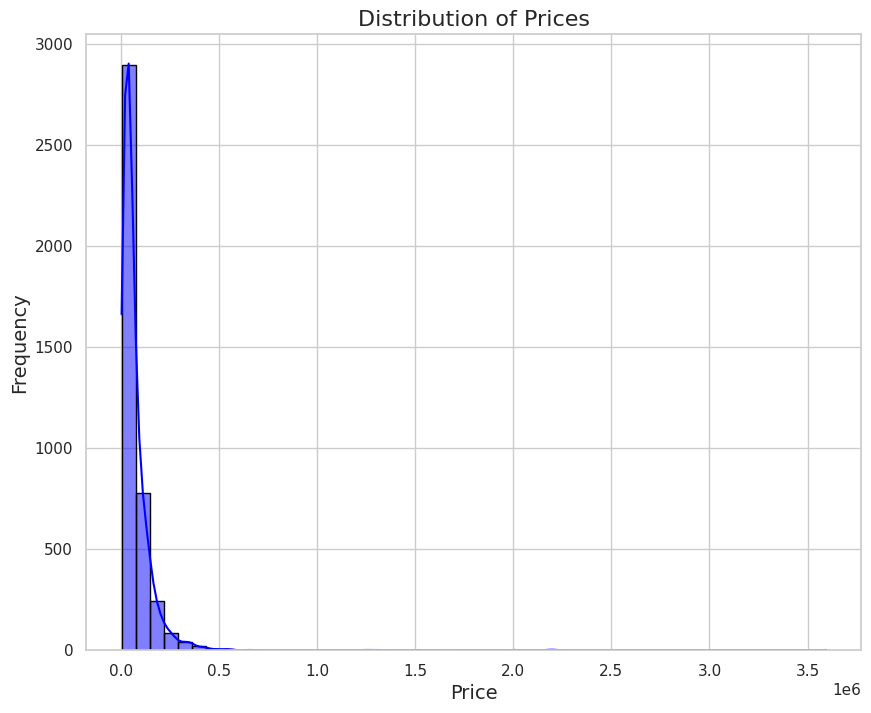

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Set the style of the plot
sns.set(style="whitegrid")

# Plot the distribution
plt.figure(figsize=(10, 8))
sns.histplot(df['price'], kde=True, bins=50, color="blue", edgecolor="black")

# Add labels and title
plt.title("Distribution of Prices", fontsize=16)
plt.xlabel("Price", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Show the plot
plt.show()
